# The Greeks
Options are powerful financial instruments that provide investors with the right, but not the obligation, to buy or sell an underlying asset at a predetermined price within a specified timeframe. While options offer opportunities for profit, they also carry inherent risks due to factors such as market volatility and price fluctuations.

Hedging is a risk management technique used to offset potential losses or limit risk exposure associated with holding an option position. By implementing hedging strategies, traders and investors can protect their portfolios from adverse market movements and maintain more stable financial positions.

In this notebook, we will explore various methods for hedging financial options using Python. We will cover essential concepts, such as delta hedging, gamma hedging, and volatility hedging. We will also discuss practical implementations of these strategies

In [1]:
from datetime import datetime
import math
import numpy as np
import pandas as pd
import yfinance as yf

## Class
We implement these strategies using a python class for the hedging of an Option.

In [2]:
import math
from scipy.stats import norm

class EuropeanCallOption:
    def __init__(self, spot_price, strike_price, risk_free_rate, volatility, time_to_maturity):
        """
        Initializes a European Call Option.

        Parameters:
            spot_price (float): Current spot price of the underlying asset.
            strike_price (float): Strike price of the option.
            risk_free_rate (float): Risk-free interest rate, typically an annualized rate.
            volatility (float): Volatility of the underlying asset's returns.
            time_to_maturity (float): Time to maturity of the option in years.
        """
        self.spot_price = spot_price
        self.strike_price = strike_price
        self.risk_free_rate = risk_free_rate
        self.volatility = volatility
        self.time_to_maturity = time_to_maturity
        
    @property
    def d1(self):
        """
        Calculates the d1 parameter used in the Black-Scholes-Merton model.

        Returns:
            float: The calculated d1 value.
        """
        d1 = (np.log(self.spot_price/self.strike_price) \
                  + (self.risk_free_rate + self.volatility**2/2)*self.time_to_maturity)\
                  / (self.volatility*np.sqrt(self.time_to_maturity))
        return d1
    
    @property
    def d2(self):
        """
        Calculates the d2 parameter used in the Black-Scholes-Merton model.

        Returns:
            float: The calculated d2 value.
        """
        d2 = self.d1 - self.volatility * np.sqrt(self.time_to_maturity)
        return d2

    @property
    def price(self):
        """
        Calculates the price of the European Call Option using the Black-Scholes-Merton model.

        Returns:
            float: The calculated option price.
        """
        option_price = self.spot_price * norm.cdf(self.d1) \
                        - self.strike_price * math.exp(-self.risk_free_rate * self.time_to_maturity) * norm.cdf(self.d2)
        return option_price
    
    @property
    def delta(self):
        original_spot = self.spot_price
        s_plus = self.spot_price*1.001
        s_minus = self.spot_price*0.999
        self.spot_price= s_plus
        theovalue_plus = self.price
        self.spot_price = s_minus
        theovalue_minus = self.price
        self.spot_price = original_spot
        return (theovalue_plus - theovalue_minus)/(s_plus-s_minus)
    
    @property
    def gamma(self):
        return norm.pdf(self.d1)\
                /(self.spot_price*self.volatility*np.sqrt(self.time_to_maturity))   

## The Case


<AxesSubplot:xlabel='Date'>

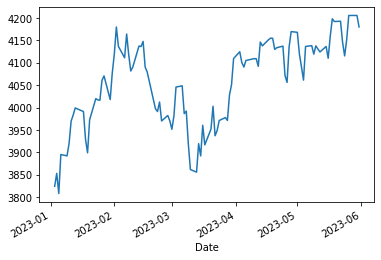

In [3]:
sp500 = yf.download('^GSPC','2023-01-01',datetime.today(), progress=False)['Close'].rename('S&P 500')
t10 = yf.download('^TNX','2023-01-01',datetime.today(), progress=False)['Close'].rename('Treasury Bill')
sp500.plot()

##### Input parameters

In [4]:
strike_price = 4100
risk_free_rate = t10/100
volatility_series = sp500.rolling(20).apply(lambda x: np.std(np.log(1+x)))
first_volatility = volatility_series.dropna()[0]
volatility_series.fillna(first_volatility, inplace=True)
maturity_date = pd.to_datetime('2023-06-15')

##### Option value over time

In [5]:
volatility_series[-1]

0.009289975161668287

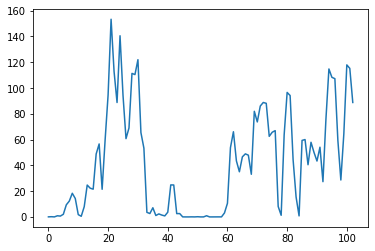

In [6]:
option_over_time = pd.Series([EuropeanCallOption(
    spot_price=spot,
    strike_price=strike_price,
    risk_free_rate=risk_free_rate[i],
    volatility=volatility_series[i],
    time_to_maturity=(maturity_date - sp500.index[i]).days/250
    )
    for i, spot in enumerate(sp500)], index=sp500.index).rename('Option Value')

option_value = pd.Series([option.price for option in option_over_time])
option_value.plot();

## Hedges
#### Delta hedge

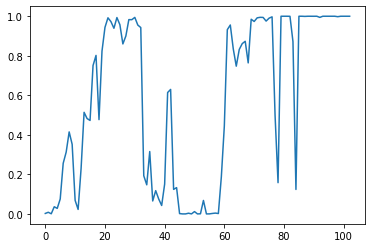

In [7]:
delta_value = pd.Series([option.delta for option in option_over_time])
delta_value.plot();

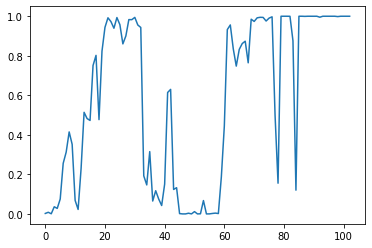

In [8]:
delta_value = pd.Series([norm.cdf(option.d1) for option in option_over_time])
delta_value.plot();

### Gamma Hedging

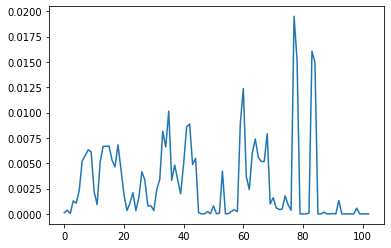

In [9]:
gamma_value = pd.Series([option.gamma for option in option_over_time])
gamma_value.plot();